<a href="https://colab.research.google.com/github/ItsSamuel10014/Python-Workshop/blob/main/Samuel_Lamilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

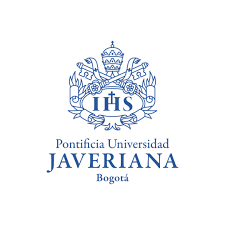
***Pontificia Universidad Javeriana***
# **Procesamiento de Alto Volumen de Datos**

Autor: Samuel Lamilla

Fecha: 26 de marzo 2025




**Objetivo**: Uso de MLLIB como Biblioteca IA en PySpark, para la creación de modelos de predicción.

La calidad del agua es un reflejo directo de la calidad de vida de los seres humanos. Junto con el aire, el agua constituye uno de los recursos más esenciales para la existencia. De manera general, se entiende por calidad del agua el conjunto de sus características físicas, químicas y biológicas. El presente estudio tiene como propósito analizar la calidad del agua en la India, utilizando como metodología el estudio del comportamiento de la contaminación y la aplicación de modelos de aprendizaje automático (ML) para su predicción.

____________________________________________________

In [1]:
## !pip install pyspark

In [2]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

**Cargar los datos (en la asignación se encuentran los datos a usar)**

In [3]:
## Se conecta con el drive de google, para tener los datos cerca
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
rutaCSV = "/content/drive/MyDrive/Colab Notebooks/waterquality.csv"
rutaIndia = "/content/drive/MyDrive/Colab Notebooks/Indian_States.shp"

In [5]:
#Importar OS de Google
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

In [6]:
df00 = spark.read.csv(rutaCSV, header=True, inferSchema=True)
gpdf00 = gpd.read_file(rutaIndia)

In [7]:
## Se hace inspeccion sobre los datos CSV
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

# **Análisis y Preparación de Datos: Archivo CSV**
Se presentan los datos que contienen los parámetros de diferentes rios en la India. Cada dato o parámetro es el promedio de valores medidos sobre un período de tiempo. Los datos han sido extraidos de la web oficial de datos de la India.


- Tipo de Datos: Coherencia de tipo de datos, transformación.
- Columnas: Conocimiento de columnas, eliminación de necesarias
- Análisis de Datos Nulos o Imposibles: Conocimiento cantidad, acción.

#Tipos de Datos: conocimiento y análisis

In [8]:
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

Se presentan los parámetros y sus definiciones de la calidad del agua en las regiones de la India. La definición de las fuentes, impactos, efectos y métodos de medida de la base de datos: no son contempladas en el presente estudio. Las definiciones de los parámetros dados por la base de datos son extraidos de **[2]**.

- STATION CODE: Código de estación
- LOCATIONS: Ubicación de estación (Ubicación del Rio)
- STATE: Estado/Lugar de la India
- TEMP: Temperatura promedio del agua (°C)
- DO: Oxigeno Disuelto (mg/L). Concentraciones altas de oxigeno disuelto representa mejor calidad del agua.
- pH: Se define como el logaritmo negativo de la concentración de hidrógeno. Número adimensional que indica la acidez o base de una solución **[3]**.
- CONDUCTIVITY: Mide la habilidad de una solución conducir corriente electrica **[4]**. El agua pura no es buen conductor de electricidad **[5]**.
- BOD: Las bacterias y otros microorganismos utilizan sustancias orgánicas como alimento (Demanda Bioquímica de Oxigeno). A medida que metabolizan la materia orgánica, consumen oxígeno **[4]**. Mayor cantidad de material orgánico en el agua, mayor valor de BOD.
- 'NITRATE_N_NITRITE_N': Nitrito y Nitrato Nitrogeno. Altas concentraciones de N en la superficie del agua puede estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L). **[4]**.
- 'FECAL_COLIFORM': Promedio de bacterias coliforms (excresiones) **[6]** .
-  'TOTAL_COLIFORM: Cantidad total de coliformes. Se retira del dataset ya que no aporta información promedio sobre los datos.

In [9]:
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

#Tipo de Datos
* Se observa que los datos se encuentran en tipo string. Se procede a cambiar a tipo de datos double.

In [10]:
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00 = df00.withColumn('TOTAL_COLIFORM', df00['TOTAL_COLIFORM'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'float')]

In [11]:
# Se elimina TOTAL_COLIFORM, no aporta a la investigación
df00 = df00.drop('TOTAL_COLIFORM')
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

# Cantidad de Datos Núlos o Imposibles.

In [12]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   5|  2|  0|          30|  6|                  2|            82|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



Se requiere limpiar los datos de los nulos o imposibles. Para ello se hará una tabla (ofrece mejor rendiminento para consultas SQL: Procesamiento de Alto Volumen de Datos) y posteriormente una consulta sql para eliminar los datos que No se requieren. A continuación los pasos:
* Se crea la tabla
* Se hace la consulta a la Tabla



In [13]:
df00.createOrReplaceTempView("df00_sql")

In [14]:
##Se hace la consulta, que retorna el df00 limpio, que se llamará df01
df01 = spark.sql('''Select * from df00_sql where TEMP is not null and
                    DO is not null and
                    pH is not null and
                    CONDUCTIVITY is not null and
                    BOD is not null and
                    NITRATE_N_NITRITE_N is not null and
                    FECAL_COLIFORM is not null''')

* Se verifica la eliminación de Datos Nulos o Imposibles

In [15]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



* Se presenta información estadística de las columnas

In [16]:
for col in df01.columns:
  df01.describe([col]).show()

+-------+------------------+
|summary|      STATION CODE|
+-------+------------------+
|  count|               447|
|   mean|2056.6196868008947|
| stddev| 750.6013394156962|
|    min|                11|
|    max|              3330|
+-------+------------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                447|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           447|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|              447|
|   mean|25.49843395369698|
| stddev| 3.31128283673611|
|    min|             10.5|
|    max|             33.8|
+-------+--------

#Visualización de los Datos
* Para cada parámetro de concentración promedio, se hará una consulta SQL desde la tabla temporal, y posteriormente se un RDD con una *función lambda* para colectar los datos (vector de datos).
* RDD (Resilient Distributed Dataset) es una estructura de datos de Apache Spark que permite procesar datos en paralelo. Los RDD son la principal abstracción de datos de Spark y se encuentran en el núcleo del sistema de computación.

* Visualización de concentraciones promedio de **pH** con **Oxigeno Disuelto**

In [17]:
#Creacion de de tablas con datos limpios para visualizar los datos
df01.createOrReplaceTempView("df01_sql")

In [18]:
#Hacer los vectores de la tabla para cada parametro
DO_parametro = spark.sql("Select DO from df01_sql")
DO_parametro = DO_parametro.rdd.map(lambda fila: fila.DO).collect()
pH_parametro = spark.sql("Select pH from df01_sql")
pH_parametro = pH_parametro.rdd.map(lambda fila: fila.pH).collect()
COND_parametro = spark.sql("Select CONDUCTIVITY from df01_sql")
COND_parametro = COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()
BOD_parametro = spark.sql("Select BOD from df01_sql")
BOD_parametro = BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()
NIN_parametro = spark.sql("Select NITRATE_N_NITRITE_N from df01_sql")
NIN_parametro = NIN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()
FC_parametro = spark.sql("Select FECAL_COLIFORM from df01_sql")
FC_parametro = FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

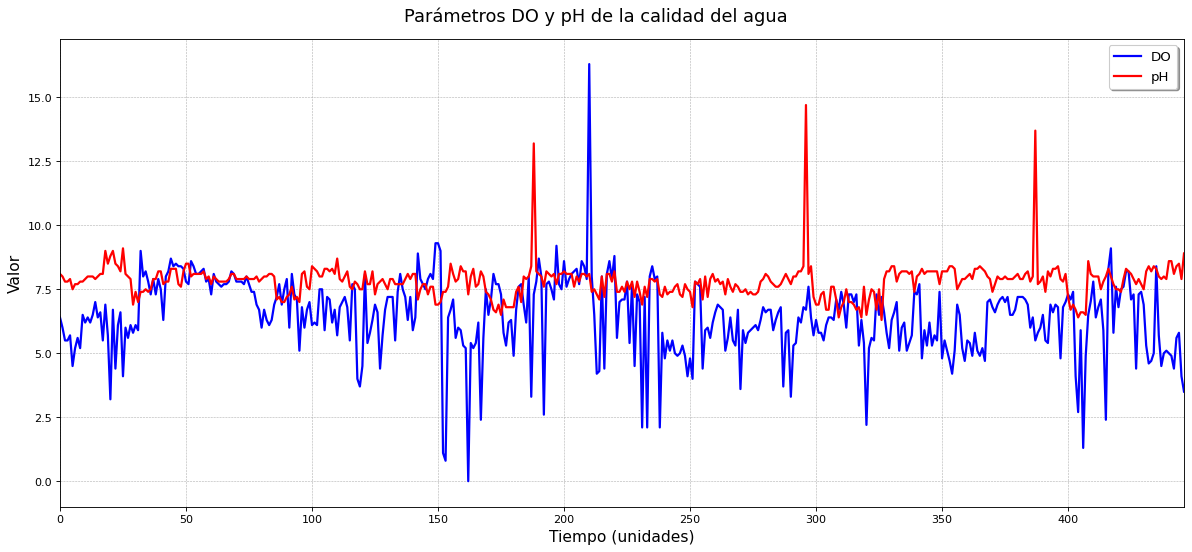

In [19]:
tam = len(DO_parametro)

fig, ax1 = plt.subplots(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')

# Usamos diferentes colores y estilos para las líneas
ax1.plot(range(0, tam), DO_parametro, label='DO', color='blue', linestyle='-', linewidth=2)
ax1.plot(range(0, tam), pH_parametro, label='pH', color='red', linestyle='-', linewidth=2)

# Añadir título y etiquetas a los ejes
fig.suptitle('Parámetros DO y pH de la calidad del agua', fontsize=16)
ax1.set_xlabel('Tiempo (unidades)', fontsize=14)
ax1.set_ylabel('Valor', fontsize=14)

# Leyenda con más visibilidad
legend = ax1.legend(loc='upper right', shadow=True, fontsize=12)

# Mejorar la rejilla con un estilo más claro
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Si hay algún rango específico de los ejes, puedes configurarlo
ax1.set_xlim(0, tam-1)
ax1.set_ylim(min(min(DO_parametro), min(pH_parametro)) - 1, max(max(DO_parametro), max(pH_parametro)) + 1)

plt.tight_layout()  # Ajusta el layout para no cortar las etiquetas
plt.show()

## En el anterior grafico podemos evidenciar la concentracion de los parámetros DO y Ph

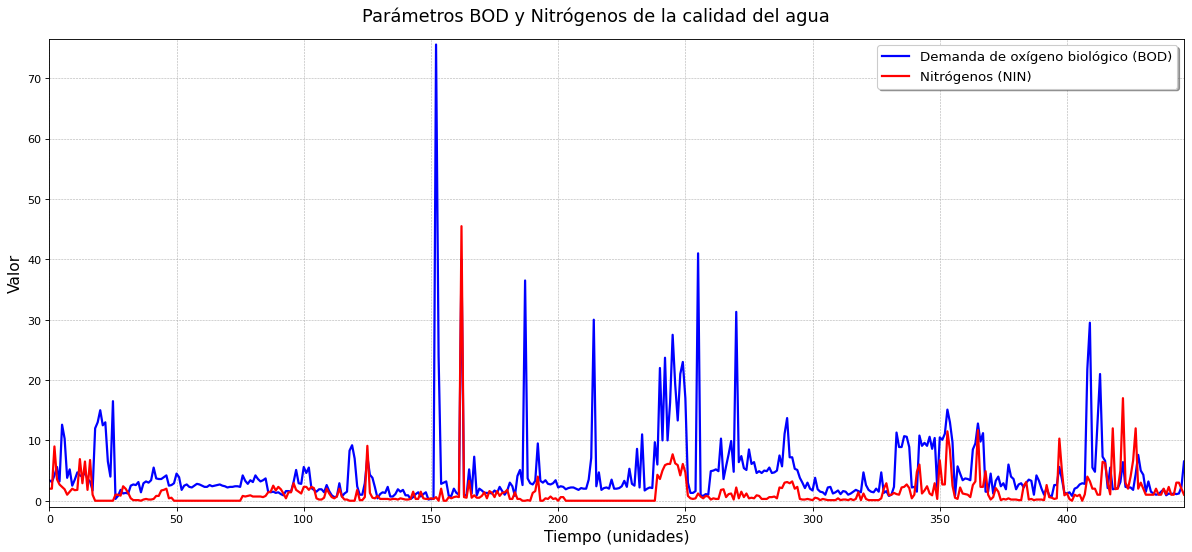

In [20]:
tam = len(BOD_parametro)

fig, ax1 = plt.subplots(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')

# Usamos diferentes colores y estilos para las líneas
ax1.plot(range(0, tam), BOD_parametro, label='Demanda de oxígeno biológico (BOD)', color='blue', linestyle='-', linewidth=2)
ax1.plot(range(0, tam), NIN_parametro, label='Nitrógenos (NIN)', color='red', linestyle='-', linewidth=2)

# Añadir título y etiquetas a los ejes
fig.suptitle('Parámetros BOD y Nitrógenos de la calidad del agua', fontsize=16)
ax1.set_xlabel('Tiempo (unidades)', fontsize=14)
ax1.set_ylabel('Valor', fontsize=14)

# Leyenda con más visibilidad
legend = ax1.legend(loc='upper right', shadow=True, fontsize=12)

# Mejorar la rejilla con un estilo más claro
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Si hay algún rango específico de los ejes, puedes configurarlo
ax1.set_xlim(0, tam-1)
ax1.set_ylim(min(min(BOD_parametro), min(NIN_parametro)) - 1, max(max(BOD_parametro), max(NIN_parametro)) + 1)

plt.tight_layout()  # Ajusta el layout para no cortar las etiquetas
plt.show()

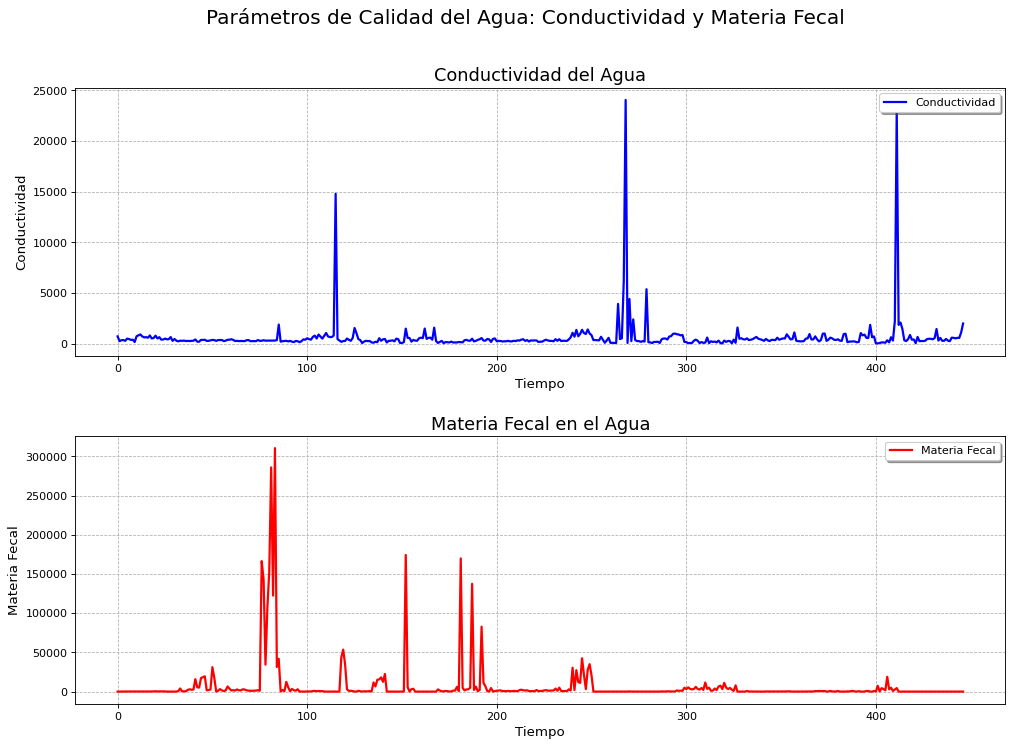

In [21]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes para los dos gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

# Graficar la conductividad en el primer gráfico
ax1.plot(range(0, tam), COND_parametro, label='Conductividad', color='b', lw=2)
ax1.set_title('Conductividad del Agua', fontsize=16)
ax1.set_xlabel('Tiempo', fontsize=12)
ax1.set_ylabel('Conductividad', fontsize=12)
ax1.legend(loc='upper right', shadow=True)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7)

# Graficar la materia fecal en el segundo gráfico
ax2.plot(range(0, tam), FC_parametro, label='Materia Fecal', color='r', lw=2)
ax2.set_title('Materia Fecal en el Agua', fontsize=16)
ax2.set_xlabel('Tiempo', fontsize=12)
ax2.set_ylabel('Materia Fecal', fontsize=12)
ax2.legend(loc='upper right', shadow=True)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7)

# Título global con un espacio extra para evitar superposiciones
fig.suptitle('Parámetros de Calidad del Agua: Conductividad y Materia Fecal', fontsize=18)

# Ajustar el espaciado para evitar superposiciones entre los subgráficos y el título global
plt.subplots_adjust(hspace=0.3)  # Ajustar espacio vertical entre los subgráficos

# Mostrar el gráfico
plt.show()


# **Ingeniería de Características**


**Water Quality Index:** El Índice de la Calidad del Agua se calcula agregando  linealmente el índice de calidad con el peso.

WQI = sum(**qr**n * **W**n)

**qr**n: Rango de Calidad para el n parámetro de calidad de agua.

**W**n: Unidad de peso para el n parámetro.

A continuación se calcula un método estándar **[2]** para calcular el rango de calidad **qr** para cada parámetro.

* Rango de calidad para **pH**. Se crea una nueva columna con los rangos **pH** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **pH = [7.0 ; 8.5]**
    + 80:  *agua moderada*     **pH = [6.8 ; 6.9) o (8.5 ; 8.6]**
    + 60:  *agua dura* **pH = [6.7 ; 6.8) o [8.6 ; 8.8)**
    + 40:  *agua muy dura* **pH = [6.5 ; 6.7) o [8.8 ; 9.0)**
    + 0:   rango agua residuales

In [22]:
#Función definida por el usuario para definir el rango de calidad de agua según el pH
#Se crea la colmumna para los rangos del parámetro

df02 = df01.withColumn(
    "qr_pH",
    F.when((df01.pH >= 7.0) & (df01.pH <= 8.5), 100)  # Agua dulce
    .when(((df01.pH >= 6.8) & (df01.pH < 7.0)) | ((df01.pH > 8.5) & (df01.pH <= 8.6)), 80)  # Agua moderada
    .when(((df01.pH >= 6.7) & (df01.pH < 6.8)) | ((df01.pH > 8.6) & (df01.pH < 8.8)), 60)  # Agua dura
    .when(((df01.pH >= 6.5) & (df01.pH < 6.7)) | ((df01.pH > 8.8) & (df01.pH <= 9.0)), 40)  # Agua muy dura
    .otherwise(0)  # Agua residual
)

* Rango de calidad para **Oxigeno Disuelto**. Se crea una nueva columna con los rangos DO de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **DO>=6.0**
    + 80:  *agua moderada* **DO = [5.1, 6.0]**
    + 60:  *agua dura* **DO = [4.1, 5.0]**
    + 40:  *agua muy dura* **DO = [3.0, 4.0]**
    + 0:   rango agua residuales

In [23]:
#Función definida por el usuario para definir el rango de calidad de agua según el DO
#Se crea la colmumna para los rangos del parámetro

df02 = df02.withColumn(
    "qr_DO",
    F.when((df01.DO >= 6.0), 100)  # Agua dulce
    .when(((df01.DO >= 5.1) & (df01.DO < 6.0)), 80)  # Agua moderada
    .when(((df01.DO >= 4.1) & (df01.DO <= 5.0)), 60)  # Agua dura
    .when(((df01.DO >= 3.0) & (df01.DO <= 4.0)), 40)  # Agua muy dura
    .otherwise(0)  # Agua residual
)

* Rango de calidad para **Conductividad**. Se crea una nueva columna con los rangos CONDUCTIVITY de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **CONDUCTIVITY = [0.0,75.0]**
    + 80:  *agua moderada* **CONDUCTIVITY = [75.0, 150.0]**
    + 60:  *agua dura* **CONDUCTIVITY = [150.0, 225.0]**
    + 40:  *agua muy dura* **CONDUCTIVITY = [225.0, 300.0]**
    + 0:   rango agua residuales

In [24]:
#Función definida por el usuario para definir el rango de calidad de agua según el DO
#Se crea la colmumna para los rangos del parámetro

df02 = df02.withColumn(
    "qr_COND",
    F.when(((df01.CONDUCTIVITY >= 0.0) & (df01.CONDUCTIVITY <= 75.0)), 100)  # Agua dulce
    .when(((df01.CONDUCTIVITY > 75.0) & (df01.CONDUCTIVITY <= 150.0)), 80)  # Agua moderada
    .when(((df01.CONDUCTIVITY > 150.0) & (df01.CONDUCTIVITY <= 225.0)), 60)  # Agua dura
    .when(((df01.CONDUCTIVITY > 225.0) & (df01.CONDUCTIVITY <= 300.0)), 40)  # Agua muy dura
    .otherwise(0)  # Agua residual
)

* Rango de calidad para **Demanda Bioquímica de Oxigeno**. Se crea una nueva columna con los rangos **BOD** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **BOD = [0.0,3.0)**
    + 80:  *agua moderada* **BOD = [3.0, 6.0)**
    + 60:  *agua dura* **BOD = [6.0, 80.0)**
    + 40:  *agua muy dura* **BOD = [80.0, 125.0)**
    + 0:   rango agua residuales

In [25]:
#Función definida por el usuario para definir el rango de calidad de agua según el DO
#Se crea la colmumna para los rangos del parámetro

df02 = df02.withColumn(
    "qr_BOD",
    F.when(((df02.BOD >= 0.0) & (df02.BOD < 3.0)), 100)  # Agua dulce
    .when(((df02.BOD >= 3.0) & (df02.BOD < 6.0)), 80)  # Agua moderada
    .when(((df02.BOD >= 6.0) & (df02.BOD < 80.0)), 60)  # Agua dura
    .when(((df02.BOD >= 80.0) & (df02.BOD < 125.0)), 40)  # Agua muy dura
    .otherwise(0)  # Agua residual
)

* Rango de calidad para **Nitratos**. Se crea una nueva columna con los rangos **NITRATE_N_NITRITE_N** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **NITRATE_N_NITRITE_N = [0.0,20.0)**
    + 80:  *agua moderada* **NITRATE_N_NITRITE_N =  [20.0, 50.0)**
    + 60:  *agua dura* **NITRATE_N_NITRITE_N = [50.0, 100.0)**
    + 40:  *agua muy dura* **NITRATE_N_NITRITE_N = [100.0, 200.0]**
    + 0:   rango agua residuales

In [26]:
#Función definida por el usuario para definir el rango de calidad de agua según el DO
#Se crea la colmumna para los rangos del parámetro

df02 = df02.withColumn(
    "qr_NIN",
    F.when(((df02.NITRATE_N_NITRITE_N >= 0.0) & (df02.NITRATE_N_NITRITE_N < 20.0)), 100)  # Agua dulce
    .when(((df02.NITRATE_N_NITRITE_N >= 20.0) & (df02.NITRATE_N_NITRITE_N < 50.0)), 80)  # Agua moderada
    .when(((df02.NITRATE_N_NITRITE_N >= 50.0) & (df02.NITRATE_N_NITRITE_N < 100.0)), 60)  # Agua dura
    .when(((df02.NITRATE_N_NITRITE_N >= 100.0) & (df02.NITRATE_N_NITRITE_N <= 200.0)), 40)  # Agua muy dura
    .otherwise(0)  # Agua residual
)

* Rango de calidad para **Coliforme Fecal**. Se crea una nueva columna con los rangos FECAL_COLIFORM de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **FECAL_COLIFORM = [0.0,5.0)**
    + 80:  *agua moderada* **FECAL_COLIFORM = [5.0, 50.0)**
    + 60:  *agua dura* **FECAL_COLIFORM = [50.0, 500.0)**
    + 40:  *agua muy dura* **FECAL_COLIFORM = [500.0, 10000.0)**
    + 0:   rango agua residuales

In [27]:
#Función definida por el usuario para definir el rango de calidad de agua según el DO
#Se crea la colmumna para los rangos del parámetro

df02 = df02.withColumn(
    "qr_FC",
    F.when(((df02.FECAL_COLIFORM >= 0.0) & (df02.FECAL_COLIFORM < 5.0)), 100)  # Agua dulce
    .when(((df02.FECAL_COLIFORM >= 5.0) & (df02.FECAL_COLIFORM < 50.0)), 80)  # Agua moderada
    .when(((df02.FECAL_COLIFORM >= 50.0) & (df02.FECAL_COLIFORM < 500.0)), 60)  # Agua dura
    .when(((df02.FECAL_COLIFORM >= 500.0) & (df02.FECAL_COLIFORM < 10000.0)), 40)  # Agua muy dura
    .otherwise(0)  # Agua residual
)

In [28]:
#Inspeccion visual
df02.show(15)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qr_pH|qr_DO|qr_COND|qr_BOD|qr_NIN|qr_FC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0|  100|  100|      0|    80|   100|  100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0|  100|  100|     40|    80|   100|   60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0|  100|   80|      0|    80|   100|   60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.

A continuación se cálcula el WQI para cada parámetro.

El peso del agua puede ser calculado por el producto de su volumen por su densidad. La densidad del agua es aproximadamente 1 gramo por centimetro cúbico (g/cm^3)

In [29]:
df03 = df02.withColumn("wHph", F.round(df02.qr_pH * 0.165, 3))
df03 = df03.withColumn("wDO", F.round(df02.qr_DO * 0.281, 3))
df03 = df03.withColumn("wCOND", F.round(df02.qr_COND * 0.234, 3))
df03 = df03.withColumn("wBOD", F.round(df02.qr_BOD * 0.009, 3))
df03 = df03.withColumn("wNIN", F.round(df02.qr_NIN * 0.028, 3))
df03 = df03.withColumn("wFC", F.round(df02.qr_FC * 0.281, 3))

In [30]:
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+----+-----+-----+----+----+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qr_pH|qr_DO|qr_COND|qr_BOD|qr_NIN|qr_FC|wHph|  wDO|wCOND|wBOD|wNIN|  wFC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+----+-----+-----+----+----+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0|  100|  100|      0|    80|   100|  100|16.5| 28.1|  0.0|0.72| 2.8| 28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0|  100|  100|     40|    80|   100|   60|16.5| 28.1| 9.36|0.72| 2.8|16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|     

# Datos sacados de la referencia

Finalmente se calcula el **Índice de Calidad del Agua**

In [31]:
# se crea la columna WQI
df04 = df03.withColumn("WQI", F.round(df03.wHph + df03.wDO + df03.wCOND + df03.wBOD + df03.wNIN + df03.wFC, 3))

In [32]:
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+----+-----+-----+----+----+-----+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qr_pH|qr_DO|qr_COND|qr_BOD|qr_NIN|qr_FC|wHph|  wDO|wCOND|wBOD|wNIN|  wFC|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+----+-----+-----+----+----+-----+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0|  100|  100|      0|    80|   100|  100|16.5| 28.1|  0.0|0.72| 2.8| 28.1|76.22|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0|  100|  100|     40|    80|   100|   60|16.5| 28.1| 9.36|0.72| 2.8|16.86|74.34|
|        2182|GODAVARI RIVER AT...|

* A continuación se clasifica el agua sobre la base de su índice de calidad **[2]**

* Clasificación de calidad del agua:

    + Excelente: *agua dulce* **WQI = [0.0,25.0]**
    + Buena:  *agua moderada* **WQI = [26.0, 50.0]**
    + Baja:  *agua dura* **WQI = [51.0, 75.0]**
    + Muy_Baja:  *agua muy dura* **WQI = [76.0, 100.0]**
    + Inadecuada:   rango agua residuales

In [33]:
df05 = df04.withColumn(
    "Water_Quality",
    F.when(((df04.WQI >= 0.0) & (df04.WQI <= 25.0)), "Excelente")  # Agua dulce
    .when(((df04.WQI >= 26.0) & (df04.WQI <= 50.0)), "Buena")  # Agua moderada
    .when(((df04.WQI >= 51.0) & (df04.WQI <= 75.0)), "Baja")  # Agua dura
    .when(((df04.WQI >= 76.0) & (df04.WQI <= 100.0)), "Muy_baja")  # Agua muy dura
    .otherwise("Podrida")  # Agua residual
)

In [34]:
df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+----+-----+-----+----+----+-----+-----+-------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qr_pH|qr_DO|qr_COND|qr_BOD|qr_NIN|qr_FC|wHph|  wDO|wCOND|wBOD|wNIN|  wFC|  WQI|Water_Quality|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+-----+-----+-------+------+------+-----+----+-----+-----+----+----+-----+-----+-------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0|  100|  100|      0|    80|   100|  100|16.5| 28.1|  0.0|0.72| 2.8| 28.1|76.22|     Muy_baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0|  100|  100|     40|    80|   100|   60|16.5| 28.1| 9.36|0.

#**Visualización de los datos por Estados de la INDIA**

* Se visualizan los datos obtenidos de CALIDAD en cada región/estado de la INDIA

In [35]:
#Primero se obtienen los nombres de regiones sobre el Dataframe de Calidad
df05.select('STATE').distinct().collect()

[Row(STATE='WEST BENGAL'),
 Row(STATE='GOA'),
 Row(STATE='RAJASTHAN'),
 Row(STATE='HIMACHAL PRADESH'),
 Row(STATE='GUJARAT'),
 Row(STATE='BIHAR'),
 Row(STATE='KARNATAKA'),
 Row(STATE='UTTAR PRADESH'),
 Row(STATE='MADHYA PRADESH'),
 Row(STATE='MAHARASHTRA'),
 Row(STATE='PUNJAB'),
 Row(STATE='TAMILNADU'),
 Row(STATE='ANDHRA PRADESH'),
 Row(STATE='KERALA'),
 Row(STATE='ASSAM')]

* Se observan los nombres en el GPD, para hacer que sean similares frente a los del dataframe

In [36]:
#Se visualiza el dataframe geográfico gpd
type(gpdf00)

geopandas.geodataframe.GeoDataFrame

In [37]:
gpdf00.columns

Index(['st_nm', 'geometry'], dtype='object')

<Axes: >

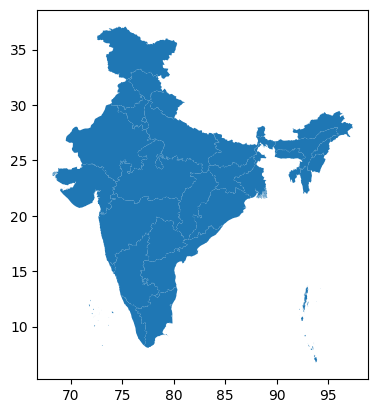

In [38]:
gpdf00.plot()

In [39]:
#Nombres de los estados en GeoPandas
gpdf00['st_nm'].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [40]:
#Se ajustan los nombres de GPD, eliminando caracteres y extensiones de nombres
gpdf01 = gpdf00.replace({'Andaman & Nicobar Island': 'Andaman and Nicobar Island',
                         'Dadara & Nagar Havelli': 'Dadara and Nagar Havelli',
                         'Daman & Diu': 'Daman and Diu',
                         'NCT of Delhi': 'Delhi',
                         'Jammu & Kashmir': 'Jammu and Kashmir'
})
gpdf01['st_nm'].unique()

array(['Andaman and Nicobar Island', 'Arunanchal Pradesh', 'Assam',
       'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadara and Nagar Havelli',
       'Daman and Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

Se hacen cambios sobre el dataframe spark para coincidir nombres

* Para efectos de pintar el mapa se pasa el spark dataframe a pandas
* El nombre de TAMILNADU se cambia por TAMIL NADU
* Se deja sólo la letra inicial mayúsula sobre Dataframe

In [41]:
#Se cambia a objeto pandas
pandasDF = df05.toPandas()

#Cambio TAMILNADU a TAMIL NADU
pandasDF['STATE'].replace('TAMILNADU', 'TAMIL NADU')

#Se deja letra inicial mayúscula en columna 'STATE'
pandasDF['STATE'] = pandasDF['STATE'].str.title()
#Se comprueba el cambio
pandasDF['STATE'].head()

,STATE
0,Maharashtra
1,Maharashtra
2,Maharashtra
3,Maharashtra
4,Maharashtra


In [42]:
#Se cambia el nombre en el gpd a STATES
gpdf02 = gpdf01.rename(columns={'st_nm': 'STATE'})
gpdf02['STATE'].unique()
#Se combinan los  dataframes (gpdf02, df11pandas) outer: union de claves 'STATE' de ambos dataframes
dfMap = pd.merge(gpdf02, pandasDF, on='STATE', how='outer')
#Se toman puntos a bajo coste que garantizan estar dentro de la geometria (mapa)

dfMap['coords'] = dfMap['geometry'].apply(
    lambda x: x.representative_point().coords[0] if x is not None else None
)

#Se eliminan los datos duplicados
dfMap = dfMap.drop_duplicates(subset='STATE')

dfMap.head(10)

,STATE,geometry,STATION CODE,LOCATIONS,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,...,qr_FC,wHph,wDO,wCOND,wBOD,wNIN,wFC,WQI,Water_Quality,coords
0,Andaman and Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(92.83153129257889, 12.611584970470062)"
1,Andhra Pradesh,"MULTIPOLYGON (((81.1038 17.82269, 81.1061 17.8...",2360.0,"GODAVARI AT BASARA, ADILABAD",28.000000,5.5,8.1,826.0,1.7,1.0,...,80.0,16.5,22.48,0.00,0.9,2.8,22.48,65.16,Baja,"(79.61537165157097, 15.893833407885495)"
35,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.1686 29.37432,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(95.03199805598612, 28.055114856615404)"
36,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.7429 26....",1260.0,BRAHAMPUTRA AT KHERGHAT (AFTER CONFL. WITH DIB...,22.299999,7.2,7.1,216.0,1.5,1.4,...,60.0,16.5,28.10,14.04,0.9,2.8,16.86,79.20,Muy_baja,"(90.76265036100918, 26.052225148671738)"
58,Bihar,"MULTIPOLYGON (((84.5072 24.26323, 84.50355 24....",1074.0,"GANGA AT BUXAR,BIHAR",24.500000,8.4,8.1,371.0,2.5,0.0,...,40.0,16.5,28.10,0.00,0.9,2.8,11.24,59.54,Baja,"(86.12533485112044, 25.902658098342613)"
118,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(76.78051175496091, 30.730184003289168)"
119,Chhattisgarh,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(81.50899708552288, 20.94914121899211)"
120,Dadara and Nagar Havelli,"POLYGON ((73.20657 20.12216, 73.20797 20.1065,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(73.00811326266309, 20.206507820529538)"
121,Daman and Diu,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(70.93083380880213, 20.71944808935791)"
122,Delhi,"POLYGON ((77.09361 28.8694, 77.10973 28.86722,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(77.12909320274471, 28.640197681028212)"


* Se procede a pintar con SEABORN

In [43]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.5 MB/s eta 0:00:00


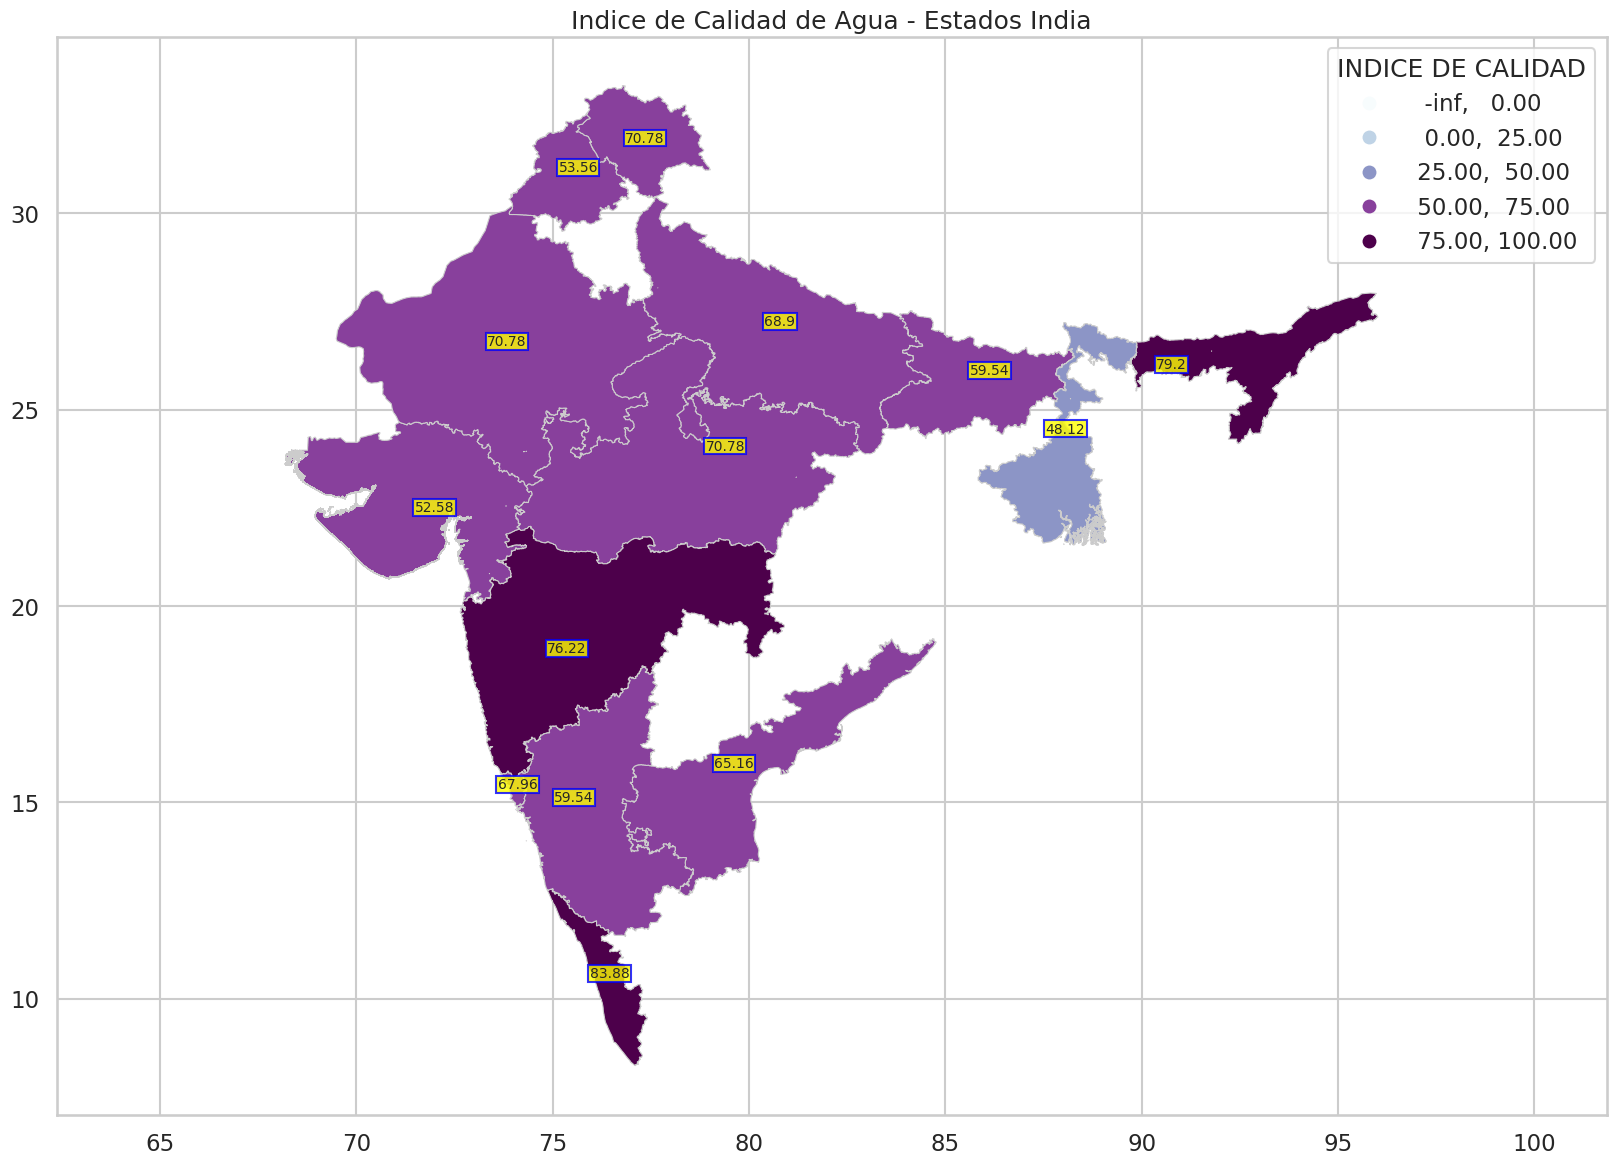

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo
sns.set_context("talk")
sns.set_style("whitegrid")

# Parámetros
cMap = 'BuPu'
sizeFig = (20, 14)

# Cambiar nombre de columna
gpdf02 = gpdf01.rename(columns={'st_nm': 'STATE'})

# Unión de dataframes
dfMap = pd.merge(gpdf02, pandasDF, on='STATE', how='outer')

# Obtener coordenadas como tuplas (x, y)
dfMap['coords'] = dfMap['geometry'].apply(
    lambda x: x.representative_point().coords[0] if x is not None else None
)

# Eliminar duplicados
dfMap = dfMap.drop_duplicates(subset='STATE')

# Eliminar filas con NaN en coords o WQI
dfMapClean = dfMap.dropna(subset=['coords', 'WQI'])

# Plot
ax = dfMapClean.plot(
    column='WQI',
    cmap=cMap,
    figsize=sizeFig,
    linewidth=0.8,
    edgecolor='0.8',
    scheme='User_Defined',
    classification_kwds=dict(bins=[0, 25, 50, 75, 100]),
    legend=True
)

# Añadir textos
for idx, row in dfMapClean.iterrows():
    x, y = row.coords
    ax.text(
        x, y,
        size=10,
        s=row['WQI'],
        horizontalalignment='center',
        bbox=dict(facecolor='yellow', alpha=0.8, edgecolor='blue', pad=1)
    )

# Títulos y formato
ax.get_legend().set_title('INDICE DE CALIDAD')
ax.set_title('Indice de Calidad de Agua - Estados India')
plt.axis('equal')
plt.show()


### Se unieron datos geoespaciales con valores del Índice de Calidad del Agua (WQI) por estado. Se generaron coordenadas representativas para ubicar etiquetas dentro del mapa. Luego, se filtraron las filas con datos incompletos para evitar errores y finalmente se visualizó el mapa con estilo, colores por rangos de WQI y etiquetas por estado.

<Axes: >

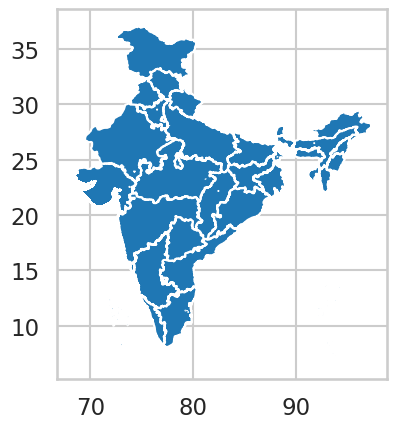

In [45]:
dfMap.plot(missing_kwds={'color': 'lightgrey'})

* Se requiere hacer una gráfica de WQI para cada STATE

In [46]:
##Se convierte el DFpandas a Dataframe spark
sparkDF00 = spark.createDataFrame(pandasDF)

#### Se crea una Tabla de Vista Temporal para hacer consultas SQL
sparkDF00.createOrReplaceTempView("df10_sql")

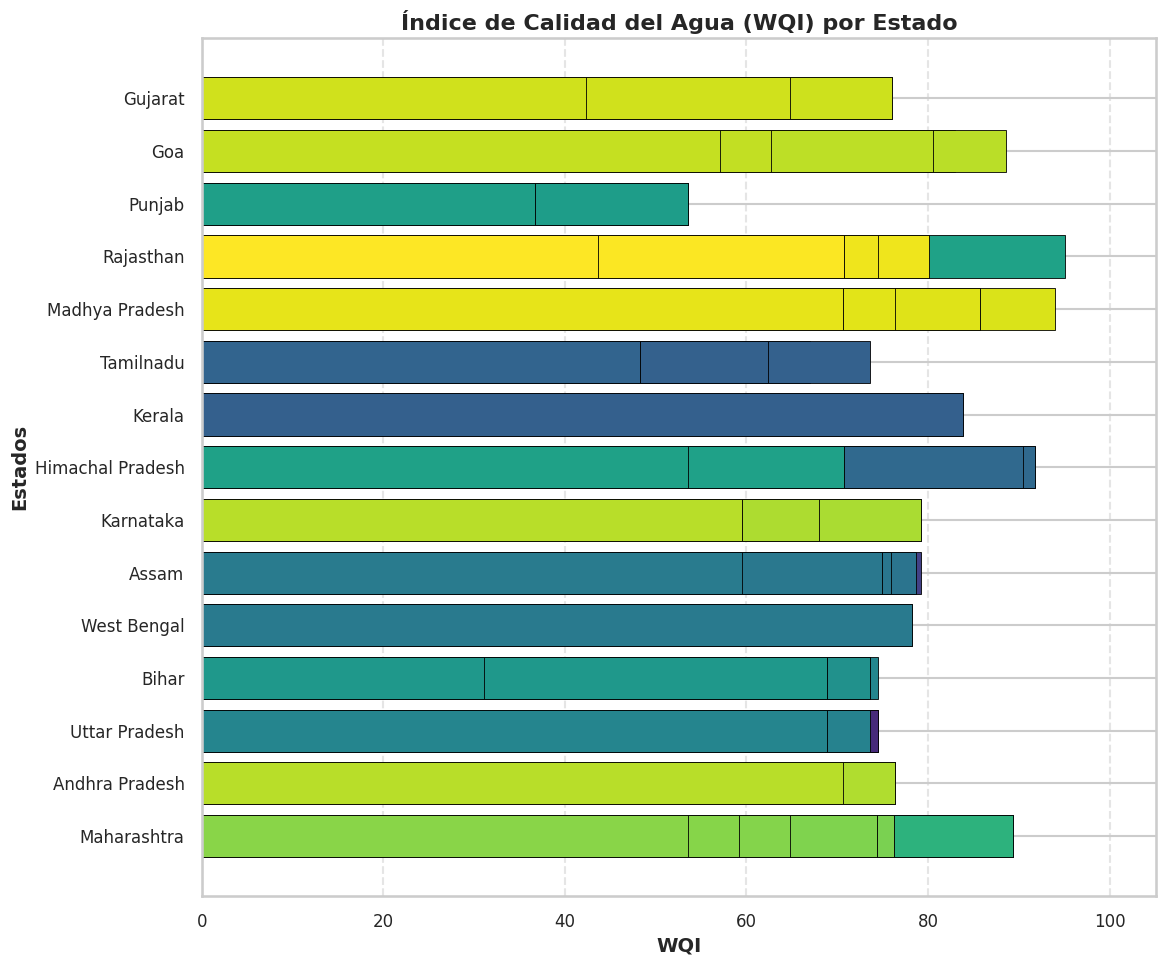

In [47]:
# Se selecciona los nombres de los estados
Estados = spark.sql("SELECT STATE FROM df10_sql")
Estados = Estados.rdd.map(lambda fila: fila.STATE).collect()

# Se seleccionan los valores de WQI
val_WQI = spark.sql("SELECT WQI FROM df10_sql")
val_WQI = val_WQI.rdd.map(lambda fila: fila.WQI).collect()

# Se visualiza un histograma
sns.set(style="whitegrid", context="talk")

if len(Estados) == len(val_WQI):
    plt.figure(figsize=(12, 10))

    # Colores suaves con buena visibilidad
    colores = sns.color_palette("viridis", len(Estados))

    # Gráfico de barras horizontales
    plt.barh(Estados, val_WQI, color=colores, edgecolor='black', linewidth=0.6)

    plt.xlabel('WQI', fontsize=14, fontweight='bold')
    plt.ylabel('Estados', fontsize=14, fontweight='bold')
    plt.title('Índice de Calidad del Agua (WQI) por Estado', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0, max(val_WQI) + 10)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Mostrar gráfico
    plt.tight_layout()
    plt.show()

else:
    print("Los datos de Estados y WQI no coinciden en cantidad")



### Se puede evidenciar las diferencias entre la cualidades del agua en los diferentes estados

#**Creación de Modelo: Regresión Lineal**

* Se requiere predecir el valor WQI
* Se crea un vector ensamblador con las columnas **"Rangos de Calidad (qr)"**
* Se normalizan las columnas a través de Normalizer
* Se importa LinearRegression y se aplica los datos con el vector normalizado
* Se hace un "pipeline" para incluir el modelo
* Se separa los datos aleatoriamente (80%:entrenamiento, 20%:prueba)
* Se entrena el modelo con los datos de entrenamiento
* Se obtienen las predicciones con los datos de prueba y se muestran
* Se revisa el rendimiento del modelo con la métrica r2

In [78]:
sparkDF00.dtypes

[('STATION CODE', 'bigint'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'double'),
 ('DO', 'double'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'double'),
 ('BOD', 'double'),
 ('NITRATE_N_NITRITE_N', 'double'),
 ('FECAL_COLIFORM', 'double'),
 ('qr_pH', 'bigint'),
 ('qr_DO', 'bigint'),
 ('qr_COND', 'bigint'),
 ('qr_BOD', 'bigint'),
 ('qr_NIN', 'bigint'),
 ('qr_FC', 'bigint'),
 ('wHph', 'double'),
 ('wDO', 'double'),
 ('wCOND', 'double'),
 ('wBOD', 'double'),
 ('wNIN', 'double'),
 ('wFC', 'double'),
 ('WQI', 'double'),
 ('Water_Quality', 'string')]

In [49]:
#Importar la biblioteca
from pyspark.ml.feature import VectorAssembler, Normalizer
#Se normalizan en un vector
vectorQR = VectorAssembler(inputCols=["qr_pH", "qr_DO", "qr_COND", "qr_BOD", "qr_NIN", "qr_FC"], outputCol="features")
normalizarQR = Normalizer(inputCol="features", outputCol="feat_Normalizada")

In [50]:
#Se prepara el modelo de Regresión Lineal
from pyspark.ml.regression import LinearRegression

modelo_A_Lineal = LinearRegression(featuresCol="feat_Normalizada", labelCol="WQI",
                                   maxIter=10, regParam=0.3, elasticNetParam=0.2)

In [51]:
from pyspark.ml import Pipeline
#Se crea el pipeline: presentar las etapas de ingesta entrenamiento final del modelo
pipe_A = Pipeline(stages=[vectorQR, normalizarQR, modelo_A_Lineal])


In [52]:
#Separación de datos aleatoriamente: 20% para prueba
train_data, test_data = sparkDF00.randomSplit([0.8, 0.2])



In [53]:
sparkDF00.dtypes

[('STATION CODE', 'bigint'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'double'),
 ('DO', 'double'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'double'),
 ('BOD', 'double'),
 ('NITRATE_N_NITRITE_N', 'double'),
 ('FECAL_COLIFORM', 'double'),
 ('qr_pH', 'bigint'),
 ('qr_DO', 'bigint'),
 ('qr_COND', 'bigint'),
 ('qr_BOD', 'bigint'),
 ('qr_NIN', 'bigint'),
 ('qr_FC', 'bigint'),
 ('wHph', 'double'),
 ('wDO', 'double'),
 ('wCOND', 'double'),
 ('wBOD', 'double'),
 ('wNIN', 'double'),
 ('wFC', 'double'),
 ('WQI', 'double'),
 ('Water_Quality', 'string')]

In [54]:
#Se crea el modelo LR para entrenamiento
LR_Modelo = pipe_A.fit(train_data)

In [55]:
# Se hacen las predicciones con los datos de entrenamiento
pred_Model_A = LR_Modelo.transform(train_data)

# Redondear la columna 'prediction' a 2 decimales
pred_Model_A.select("WQI", "prediction").show(10)

+-----+-----------------+
|  WQI|       prediction|
+-----+-----------------+
|76.22|75.14134947997827|
| 76.4|74.90100423482995|
|74.34|73.55764425387747|
|74.52|73.41164117050951|
|59.54|60.35340168418364|
| 68.9|68.79694667694373|
|48.12|50.13127054025656|
|48.12|50.13127054025656|
|48.12|50.13127054025656|
|48.12|50.13127054025656|
+-----+-----------------+
only showing top 10 rows



In [56]:
#Se hacen las predicciones con los datos de prueba
pred_Model_A = LR_Modelo.transform(test_data)

# Redondear la columna 'prediction' a 2 decimales
pred_Model_A.select("WQI", "prediction").show(10)

+-----+------------------+
|  WQI|        prediction|
+-----+------------------+
| 20.2|10.197479455264812|
| 68.9| 68.79694667694373|
|59.36| 59.85815785865919|
|59.54| 60.35340168418364|
|48.12| 50.13127054025656|
|59.36| 59.85815785865919|
|59.54| 60.35340168418364|
|59.54| 60.35340168418364|
|48.12| 50.13127054025656|
|68.72| 68.71843305413425|
+-----+------------------+
only showing top 10 rows



In [57]:
#Rendimiento del modelo con r2 como métrica
metricaR2 = LR_Modelo.stages[2].summary.r2
print(f'La métrica de rendimiento de R² para el Modelo Lineal es= {(metricaR2 * 100)}%')

La métrica de rendimiento de R² para el Modelo Lineal es= 97.84288821617348%


#**Creación de Modelo: Aprendizaje Profundo (Deep Learning)**

* Se requiere predecir el valor WQI
* Se crea un DF en pandas, se crea los vectores numpy de columnas **"Rangos de Calidad (qr)"** y **WQI**
* Se importa Scikit-Learn, para separar los datos (20% para prueba)
* Se importa Keras Sequential con layers Dense
* Se inicializa el modelo, y se añaden las capas
* Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
* Se realiza el entrenamiento

In [58]:
!pip install tensorflow


In [59]:
pandasDF.columns

Index(['STATION CODE', 'LOCATIONS', 'STATE', 'TEMP', 'DO', 'pH',
       'CONDUCTIVITY', 'BOD', 'NITRATE_N_NITRITE_N', 'FECAL_COLIFORM', 'qr_pH',
       'qr_DO', 'qr_COND', 'qr_BOD', 'qr_NIN', 'qr_FC', 'wHph', 'wDO', 'wCOND',
       'wBOD', 'wNIN', 'wFC', 'WQI', 'Water_Quality'],
      dtype='object')

***Se hace uso de la biblioteca Scikit-Learn para aplicar Deep***


In [60]:
#Se obtienen en vector numpy datos de los rangos de calidad de los parámetros (qrParametros)
datos = pandasDF.iloc[:, 10:16].values
#Se obtienen en vector numpy datos de valor a predecir "WQI"
prede = pandasDF.iloc[:, 22:23].values

In [61]:
#Separación de datos con scikit-learn: train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datos, prede, test_size=0.2, random_state=1)

In [62]:
print(f"Cantidad de datos totales = {pandasDF.shape}")
print(f"Cantidad de datos de entrenamiento = {X_train.shape}")
print(f"Cantidad de datos de prueba = {X_test.shape}")
print(f"Cantidad Prediccion Entrenamiento = {y_train.shape}")
print(f"Cantidad Prediccion Prueba = {y_test.shape}")

Cantidad de datos totales = (447, 24)
Cantidad de datos de entrenamiento = (357, 6)
Cantidad de datos de prueba = (90, 6)
Cantidad Prediccion Entrenamiento = (357, 1)
Cantidad Prediccion Prueba = (90, 1)


In [68]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [69]:
#Se ajustan las variables
epocas = 200
lotes = 81
#Se inicializa el modelo con las capas
modelo_DL = Sequential()
modelo_DL.add(Dense(350, input_dim=6, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(1, activation='linear'))


In [70]:
## Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelo_DL.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse'])
#

In [71]:
#Se presenta el resumen del modeloDL
modelo_DL.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 350)                 │           2,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
##Se entrena el modelo
rendi_Mod_DL = modelo_DL.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1864.6123 - mse: 1864.6123
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 136.1167 - mse: 136.1167
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 37.6663 - mse: 37.6663
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.3495 - mse: 11.3495
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1756 - mse: 3.1756
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8417 - mse: 1.8417
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7184 - mse: 0.7184
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2919 - mse: 0.2919
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1763 - mse: 0.1763
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1904 - mse: 0.1904
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0970 - mse: 0.0970
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1143 - mse: 0.1143
Epoch 13/50
12/12 ━━━━━

In [83]:
#Se calcula la predicción
pred_DL_Train = modelo_DL.predict(X_train)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [82]:
pred_DL_Test = modelo_DL.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


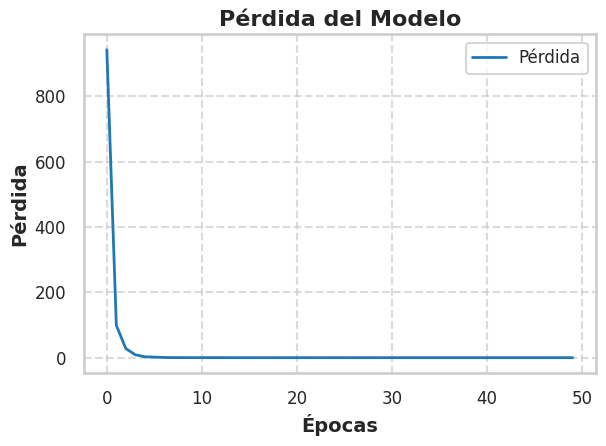

In [84]:
# Se pinta la pérdida: rendimiento del modelo
plt.plot(rendi_Mod_DL.history['loss'], color='tab:blue', linewidth=2, label='Pérdida')
plt.title('Pérdida del Modelo', fontsize=16, fontweight='bold')
plt.xlabel('Épocas', fontsize=14, fontweight='bold')
plt.ylabel('Pérdida', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Añadir una leyenda
plt.legend(loc='upper right', fontsize=12)

# Ajuste de los márgenes para mejor visualización
plt.tight_layout()

# Mostrar gráfico
plt.show()

###Al inicio del entrenamiento (Época 0), la pérdida del modelo presenta un valor muy elevado, superando los 600, lo cual es habitual cuando los parámetros se inicializan de forma aleatoria sin ningún conocimiento previo. Durante las primeras épocas (aproximadamente 0-5), se produce una reducción drástica y acelerada de la pérdida, indicando que el modelo está aprendiendo rápidamente de los datos y ajustando sus parámetros de manera eficiente para minimizar los errores. A medida que avanza el entrenamiento (épocas 5-50), la curva de pérdida se estabiliza, mostrando una disminución mucho más gradual y suave, casi asintótica, hasta alcanzar un valor muy cercano a cero, lo que sugiere que el modelo ha logrado un alto nivel de precisión y que los ajustes posteriores son cada vez más refinados.

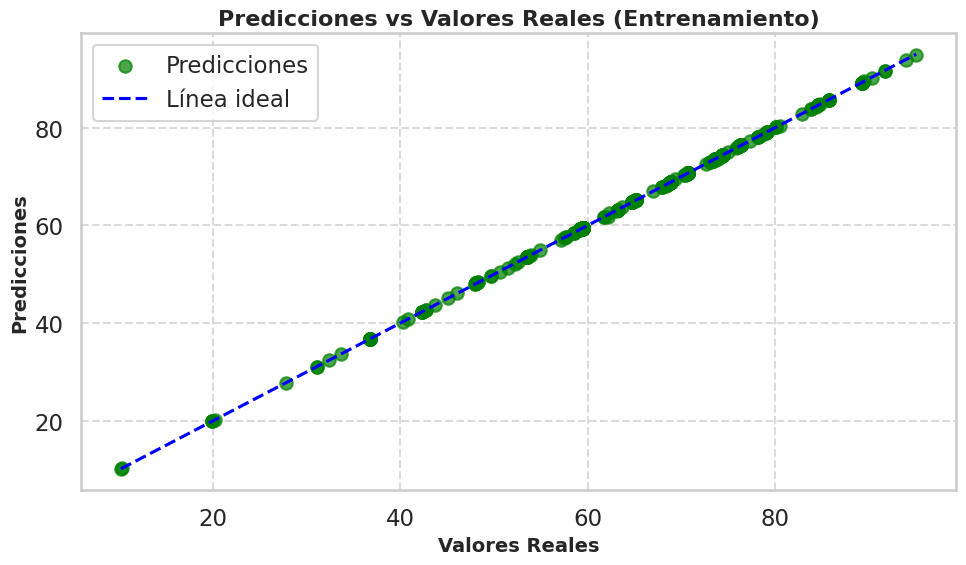

In [85]:
# Se pinta las predicciones sobre datos conocidos (entrenamiento)
plt.figure(figsize=(10, 6))
plt.scatter(y_train, pred_DL_Train, color='green', label='Predicciones', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='blue', linestyle='--', label='Línea ideal')

plt.title('Predicciones vs Valores Reales (Entrenamiento)', fontsize=16, fontweight='bold')
plt.xlabel('Valores Reales', fontsize=14, fontweight='bold')
plt.ylabel('Predicciones', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

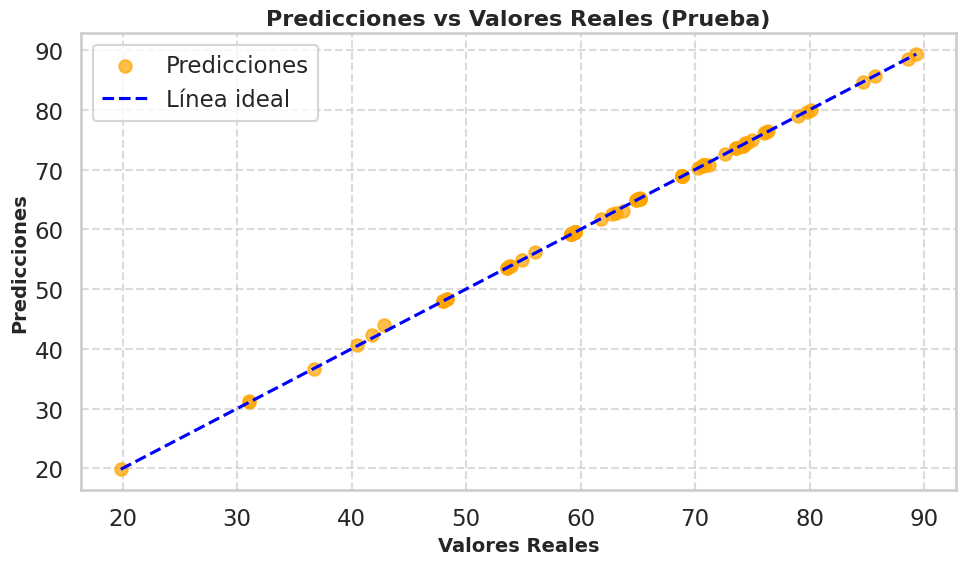

In [86]:
# Se pinta las predicciones sobre datos desconocidos (prueba)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_DL_Test, color='orange', label='Predicciones', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Línea ideal')

plt.title('Predicciones vs Valores Reales (Prueba)', fontsize=16, fontweight='bold')
plt.xlabel('Valores Reales', fontsize=14, fontweight='bold')
plt.ylabel('Predicciones', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Se puede evidenciar que las predicciones se encuentran alineadas con la realidad, lo que sugiere que el modelo es bastante preciso

#**Predicción de la Calidad del Agua**

* Hasta ahora se predice el Indice de Calida de Agua.
* Se requiere clasificar el agua según el WQI que se predice y así predecir su calidad.
* Se crea un modelo de Regresión Logística para predecir valores por categorias.
* La columna 'CALIDAD' contiene formato 'string', se convierte a 'StringIndexer'
* Se crea un vector assembler para los datos del índice
* Se normaliza los valores en el vector

In [108]:
#Se convierte a spark dataframe
sparkDF01 = spark.createDataFrame(pandasDF)

In [109]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression

In [117]:
# Assuming  is the column name and sparkDF01 is your DataFrame
indexer = StringIndexer(inputCol="Water_Quality", outputCol="Water_Quality_index")
vectorA2 = VectorAssembler(inputCols=["qr_pH", "qr_DO", "qr_COND", "qr_BOD", "qr_NIN", "qr_FC"], outputCol="features2")
normalizarA2 = Normalizer(inputCol="features2", outputCol="feat_normal2")


# Se cre el modelo
lr = LogisticRegression(featuresCol='feat_normal2', labelCol='Water_Quality_index')

# Update the pipeline
pipeline_B = Pipeline(stages=[indexer, vectorA2, normalizarA2, lr])


In [118]:
# Se dividen los datos para entrenamiento y prueba (Usando randomSplit)
train_dataB, test_dataB = sparkDF01.randomSplit([0.8, 0.2], seed = 11)
lr_model = pipeline_B.fit(train_dataB)

In [126]:
#### Predicción sobre entrenamiento
pred_train2 = lr_model.transform(train_data)
pred_train2.select("Water_Quality", "prediction").show(10)

### Se observan

+-------------+----------+
|Water_Quality|prediction|
+-------------+----------+
|     Muy_baja|       1.0|
|     Muy_baja|       1.0|
|         Baja|       0.0|
|         Baja|       0.0|
|         Baja|       0.0|
|         Baja|       0.0|
|        Buena|       2.0|
|        Buena|       2.0|
|        Buena|       2.0|
|        Buena|       2.0|
+-------------+----------+
only showing top 10 rows



In [127]:
#### Predicción sobre prueba
pred_test2 = lr_model.transform(test_data)
pred_test2.select("Water_Quality", "prediction").show(10)


### Se observan


+-------------+----------+
|Water_Quality|prediction|
+-------------+----------+
|    Excelente|       2.0|
|         Baja|       0.0|
|         Baja|       0.0|
|         Baja|       0.0|
|        Buena|       2.0|
|         Baja|       0.0|
|         Baja|       0.0|
|         Baja|       0.0|
|        Buena|       2.0|
|         Baja|       0.0|
+-------------+----------+
only showing top 10 rows



* Se revisa el rendimiento (métrica) del modelo RL

Precisión del modelo: 0.9457
Puntaje F1: 0.9510
Precisión ponderada: 0.9563
Recall ponderado: 0.9457


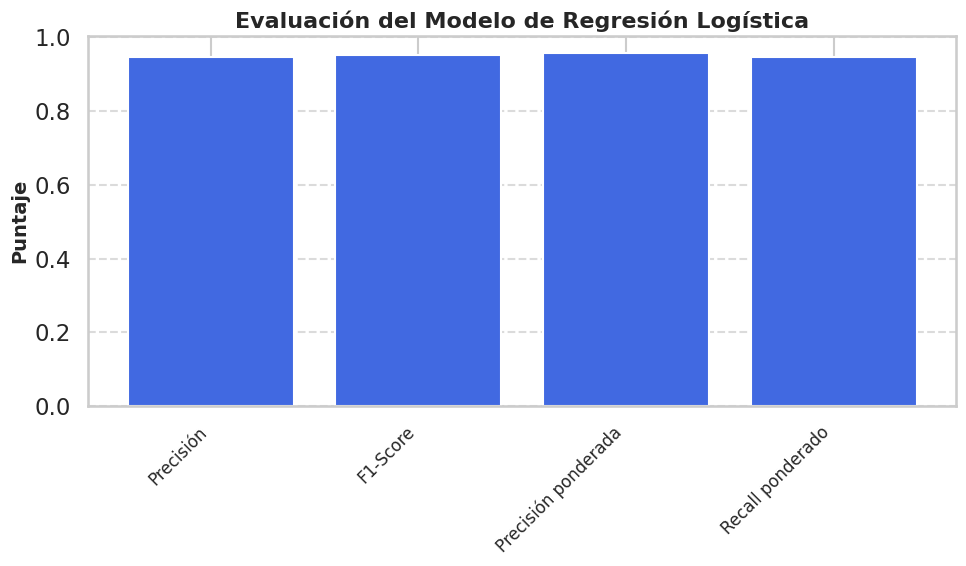

In [128]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el pipelineCAl configurado con los pasos previos
# Entrenamos el modelo
lr_model = pipeline_B.fit(train_data)

# Realizamos las predicciones sobre el conjunto de prueba
predictions = lr_model.transform(test_data)

# Usamos MulticlassClassificationEvaluator para evaluar el modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol="Water_Quality_index", predictionCol="prediction", metricName="accuracy"
)

# Evaluamos la precisión (accuracy)
accuracy = evaluator.evaluate(predictions)
print(f"Precisión del modelo: {accuracy:.4f}")

# También podemos evaluar otras métricas como F1-score, precisión, recall, etc.
evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions)
print(f"Puntaje F1: {f1_score:.4f}")

evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)
print(f"Precisión ponderada: {precision:.4f}")

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)
print(f"Recall ponderado: {recall:.4f}")

# Si quieres graficar el rendimiento en términos de precisión y F1-score:
metrics = ['Precisión', 'F1-Score', 'Precisión ponderada', 'Recall ponderado']
values = [accuracy, f1_score, precision, recall]

# Configuramos el tamaño de la figura
plt.figure(figsize=(10, 6))

# Creamos el gráfico de barras
plt.bar(metrics, values, color='royalblue')

# Añadimos etiquetas y título
plt.ylabel('Puntaje', fontsize=14, fontweight='bold')
plt.title('Evaluación del Modelo de Regresión Logística', fontsize=16, fontweight='bold')

# Mejoramos las etiquetas del eje x para evitar superposición
plt.xticks(rotation=45, ha='right', fontsize=12)

# Añadimos una cuadrícula para mejorar la legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustamos el diseño para que no se recorten las etiquetas
plt.tight_layout()

# Mostramos el gráfico
plt.show()


La evaluación del modelo se realiza con el MulticlassClassificationEvaluator, que calcula varias métricas clave de rendimiento. Se evaluaron cuatro métricas diferentes: precisión (accuracy), puntaje F1, precisión ponderada y recall ponderado. Estas métricas son útiles para entender el rendimiento del modelo, especialmente cuando se trata de clasificaciones multiclase.

Finalmente, los resultados se presentan en un gráfico de barras que compara estas métricas para una mejor visualización de la efectividad del modelo.

Análisis de los resultados:
La precisión del modelo es de 0.9639, lo que significa que el 96.39% de las predicciones realizadas por el modelo fueron correctas. Este valor es bastante alto, lo que indica que el modelo tiene un buen rendimiento general.

El puntaje F1 es de 0.9582, un valor cercano a 1, lo que muestra que el modelo mantiene un buen balance entre precisión y recall. Esta métrica es especialmente útil en escenarios donde es importante tanto evitar falsos positivos como falsos negativos, lo que es típico en problemas de clasificación.

La precisión ponderada de 0.9536 muestra que, aunque el modelo tiene un rendimiento ligeramente inferior al de la precisión general, sigue siendo muy bueno al considerar el número de instancias en cada clase. Esto indica que el modelo ha manejado bien las clases desbalanceadas (si las hubiera).

El recall ponderado de 0.9639 es casi idéntico a la precisión, lo que sugiere que el modelo también es muy eficaz para identificar todas las instancias de las clases positivas sin omitir demasiadas. Un valor de recall alto es clave cuando se desea asegurar que todas las instancias relevantes sean clasificadas correctamente.

Conclusión:
En general, los resultados obtenidos son muy positivos, con un modelo de regresión logística que ha mostrado un rendimiento excelente. Los valores altos de precisión, F1-score, precisión ponderada y recall ponderado indican que el modelo ha sido capaz de clasificar correctamente la mayoría de las instancias y manejar bien el balance entre precisión y recall. Este tipo de modelo sería útil en aplicaciones donde la minimización de falsos positivos y falsos negativos es crucial.

In [129]:
##Se obtienen las categorias
sparkDF01.select('Water_Quality').distinct().collect()

[Row(Water_Quality='Muy_baja'),
 Row(Water_Quality='Podrida'),
 Row(Water_Quality='Excelente'),
 Row(Water_Quality='Buena'),
 Row(Water_Quality='Baja')]

In [130]:
categoria = ['Muy_Baja', 'Baja', 'Inadecuada', 'Excelente']

In [131]:
#Se crea una tabla temporal
pred_train2.createOrReplaceTempView("pred2_train_sql")


In [133]:
pred_Cat = spark.sql("Select prediction from pred2_train_sql")
pred_Cat = pred_Cat.rdd.map(lambda fila: int(fila.prediction)).collect()

calidadRL = spark.sql("Select Water_Quality_index from pred2_train_sql")
calidadRL = calidadRL.rdd.map(lambda fila: int(fila.Water_Quality_index)).collect()

In [148]:
#Se presentan las primeras 20 predicciones del entrenamiento
for x in range(20):
  print(f"Predicción T: {categoria[pred_Cat[x]]} - Calidad Real: {categoria[calidadRL[x]]}")

Predicción T: Baja - Calidad Real: Baja
Predicción T: Baja - Calidad Real: Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Muy_Baja - Calidad Real: Muy_Baja
Predicción T: Inadecuada - Calidad Real: Inadecuada
Predicción T: Muy_Baja - Calidad Real: Muy_Baja


## Conclusiones
A lo largo del desarrollo de este trabajo se implementaron modelos de regresión lineal y regresión logística utilizando Python como lenguaje de programación y Google Colab como entorno de desarrollo. Estas técnicas permitieron abordar de manera efectiva la predicción de la variable de calidad, con resultados ampliamente satisfactorios en la mayoría de los casos.

La regresión lineal fue útil para entender la relación entre variables continuas, mientras que la regresión logística demostró ser una herramienta poderosa al clasificar correctamente distintos niveles de calidad, como “Baja”, “Muy_Baja” e “Inadecuada”. La coherencia entre las predicciones y los valores reales fue notable, como se evidencia en los siguientes ejemplos de coincidencia exacta entre la predicción del modelo y la calidad real observada:

    Predicción T: Muy_Baja - Calidad Real: Muy_Baja

    Predicción T: Inadecuada - Calidad Real: Inadecuada

    Predicción T: Baja - Calidad Real: Baja

Estos aciertos frecuentes reflejan la buena capacidad predictiva del modelo y una adecuada elección de las variables independientes.

En cuanto al uso de Google Colab, este entorno ofreció múltiples bondades, como:

 - Acceso gratuito a recursos computacionales en la nube (incluyendo GPUs).

 - Facilidad para compartir, colaborar y documentar el trabajo de forma dinámica.

 - Integración fluida con librerías como scikit-learn, pandas y matplotlib.

Sin embargo, también se identificaron algunas limitaciones, tales como:

 - Dependencia de conexión a internet para su funcionamiento.

 - Tiempo limitado de sesión y posibles desconexiones automáticas.

 - Restricciones en el uso prolongado de recursos, especialmente cuando se utilizan modelos más pesados.

En resumen, el trabajo evidenció que, tanto la regresión lineal como la logística, cuando son aplicadas correctamente y respaldadas por un entorno como Colab, pueden ser herramientas altamente eficaces para el análisis y la predicción de datos. Los resultados obtenidos no solo fueron mayoritariamente positivos, sino que también reflejan la viabilidad del uso de técnicas de machine learning en contextos reales y prácticos.

# **Referencias**

* **[1]** Spellman FR. Handbook of Water and Wastewater Treatment Plant Operations. 3rd ed. Boca Raton: CRC Press; 2013.
* **[2]** Summer Kevin. [Water Quality](https://www.intechopen.com/chapters/69568). IntechOpen; DOI 978-1-78985-578-4.2020.
* **[3]** Hammer MJ. Water and Wastewater Technology. 7th ed. Upper Saddle River: Pearson education; 2011.
* **[4]** Tchobanoglous G, Burton FL, Stensel HD. Metcalf & Eddy Wastewater Engineering: Treatment and Reuse. 4th ed. New Delhi: Tata McGraw-Hill Limited; 2003.
* **[5]** Alley ER. Water Quality Control Handbook. Vol. 2. New York: McGraw-Hill; 2007.

* **[6]** Nathanson JA. Basic Environmental Technology: Water Supply. New Delhi: Printice-Hall of India; 2004

